# Gradient Boosting Classifier on ResNet Embeddings

**Objective:**
Use `GradientBoostingClassifier` on your CNN-extracted features. We’ll go through:

1. Imports & setup
2. Data loading & quick sanity checks
3. Baseline training & evaluation
4. Hyperparameter search
5. Final evaluation on test set
6. Feature‐importance analysis
7. Comparison & takeaways

---

## 1. Imports & setup

In [1]:
# standard libs
import numpy as np
import matplotlib.pyplot as plt

# modeling & evaluation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# any utilities you’ve been using (e.g., for 3D viz)
from sklearn.decomposition import PCA
# from your_project.utils import plot_3d_embeddings  # if you have one

# fix the random seed for reproducibility
RANDOM_STATE = 42

In [2]:
## 2. Data Loading & Sanity Checks

In [3]:
# load your precomputed embeddings
data = np.load("galaxy10_resnet101_embeddings_augmented_balanced_regularized.npz", allow_pickle=True)
X_train, y_train = data['train_features'], data['train_labels']
X_val,   y_val   = data['val_features'],   data['val_labels']
X_test,  y_test  = data['test_features'],  data['test_labels']

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (48970, 2048) (48970,)
Validation set: (3269, 2048) (3269,)
Test set: (3268, 2048) (3268,)


*Optional sanity check:*

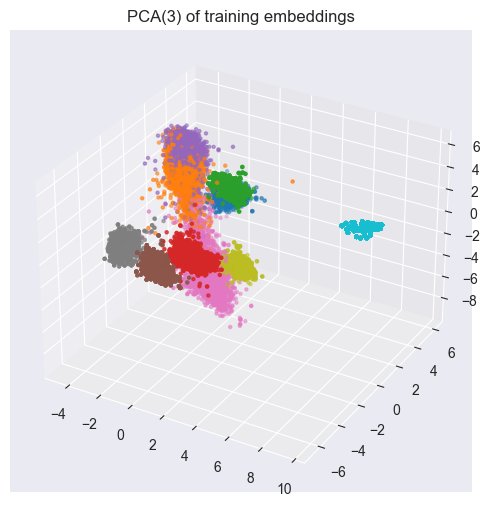

In [4]:
# PCA to 3D for a quick scatter
pca = PCA(n_components=3, random_state=RANDOM_STATE)
X3d = pca.fit_transform(X_train)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
scatter = ax.scatter(X3d[:,0], X3d[:,1], X3d[:,2], c=y_train, s=5, cmap='tab10')
plt.title("PCA(3) of training embeddings")
plt.show()

In [5]:
## 3. Baseline Training & Evaluation

In [7]:
# baseline with default hyperparameters
gbc = GradientBoostingClassifier(
    random_state=RANDOM_STATE,
    verbose=1,
)
gbc.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.4757         1310.25m
         2           1.1287         1311.01m
         3           0.8983         1304.94m
         4           0.7289         1297.45m
         5           0.5986         1291.24m
         6           0.4952         1284.32m
         7           0.4119         1277.48m
         8           0.3443         1270.73m
         9           0.2889         1263.87m
        10           0.2433         1257.69m


KeyboardInterrupt: 

In [ ]:
# evaluate on validation set
y_val_pred = gbc.predict(X_val)
print("<Baseline Validation Report>\n", classification_report(y_val, y_val_pred))

In [ ]:
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, cmap='Blues')
plt.title("Baseline Confusion Matrix (val)")
plt.show()

## 4. Hyperparameter Search

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid = GridSearchCV(
    GradientBoostingClassifier(random_state=RANDOM_STATE),
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

## 5. Final Evaluation on Test Set

In [ ]:
# use the best estimator from grid search
best_gbc = grid.best_estimator_
y_test_pred = best_gbc.predict(X_test)

print("<Test Set Report>\n", classification_report(y_test, y_test_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, cmap='Oranges')
plt.title("Best GBC Confusion Matrix (test)")
plt.show()

*Optional 3D viz of test labels vs. preds:*

In [ ]:
# X_test_3d = pca.transform(X_test)
# plot_3d_embeddings(X_test_3d, y_test, y_test_pred)

## 6. Feature Importance Analysis

In [ ]:
importances = best_gbc.feature_importances_
# get top-20 dimensions
top_idx = np.argsort(importances)[-20:]

plt.figure(figsize=(6,8))
plt.barh(range(len(top_idx)), importances[top_idx])
plt.yticks(range(len(top_idx)), [f"Dim {i}" for i in top_idx])
plt.xlabel("Importance")
plt.title("Top 20 Embedding Dimensions")
plt.tight_layout()
plt.show()



*Mini-experiment idea:*
> Drop the lowest-importance 500 dims, retrain, and compare accuracy drop.

---


## 7. Comparison & Takeaways
- **Bias vs. Variance:**
- GBC reduced bias compared to RF; compare metrics side by side.
- **Training time:**
- Record `.fit()` times for RF vs. GBC.
- **Class‐specific performance:**
- Which galaxy classes saw the biggest gain?
